<a href="https://colab.research.google.com/github/tallerzalan/Deep-Learning-Summer-School/blob/main/Exam/Deep_Learning_Project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Deep Learning Project

## Created by Group 11:

- Damian Trzciński
- Sandi Julardzija
- Zalán Tallér

In [ ]:
pip install split-folders

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
import os, os.path, shutil
import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt

import keras.backend as K
from keras.models import Model, Sequential
from keras.layers import Input, Dense, Flatten, Dropout, BatchNormalization
from keras.layers import Conv2D, SeparableConv2D, MaxPooling2D, LeakyReLU, Activation
from tensorflow.keras.optimizers import Adam
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, EarlyStopping
import tensorflow as tf
from tensorflow.keras.utils import plot_model

from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import splitfolders

seed = 2137
np.random.seed(seed)
tf.random.set_seed(seed)

## Data Management

### Splitting the dataset into folders

In [ ]:
# Variable for where the data is located in our local harddrive
folder_path = '.../output'

# Creating a variable "images" where we go through the images in the whole folder
images = [f for f in os.listdir(folder_path) if os.path.isfile(os.path.join(folder_path, f))]

"""
Sometimes there was a "DS store" file on Mac. We used the below pop function to remove it.
It is not necessary for Windows, thus we have "muted" the line below.
"""
#images.pop(415)

# We remove Einstein in our dataset and the corresponding pneumonia to make the dataset balanced.
images.remove('385_normal.jpg')
images.remove('385_pneumonia.jpg')

# Sanity check for number of images loaded
print(len(images))

### Creating train, validation, test sets


In [ ]:
"""
For loop that splits the image file name into three parts.
The split happens at "_" and ".".
The file names look like: "number"_"classname".img.
We are interested in "classname" which is in the middle and turning this name into a new folder.
"""

for image in images:
  folder_name = image.split('_')[1].split('.')[0]
# Join folder_name by adding it into our source folder where we have our data
  new_path = os.path.join(folder_path, folder_name)
# First time this folder would not exist so we will create it, which is only necessary the first iteration
  if not os.path.exists(new_path):
    os.makedirs(new_path)
    
# Now we can also take this specific image and ensure that the image will be put in the new folder
  old_image_path = os.path.join(folder_path, image)
  new_image_path = os.path.join(new_path, image)
  shutil.move(old_image_path, new_image_path)

# This function allows us to add a ratio into how we will separate the dataset.
# Seed is for reproducability
splitfolders.ratio(folder_path,
                   output = folder_path,
                   seed = seed,
                   ratio = (0.8, 0.15, 0.05))

"""
Selected 80% of data for training, 15% for validation and 5% for testing.
A common practice of DS is to  do 80/20 split when doing train/test split.
In our case we needed to reserve data for validation inbetween.
We wanted to feed the models with as much data as possible, at the same time having sufficient amount of data to validate the results.
"""

## Data Manipulation

### Creating the ImageDataGenerator

In [ ]:
folder_path = '/content/drive/MyDrive/Colab Notebooks/output'

"""
Data augmentation, specifically image augmentation in our case, is a technique we can use to prevent overfitting.
This is done by expanding the size of the training dataset by making transformed version of the images in the dataset.
These transformations or modification we can somewhat control with the parameters in the function.
We used the ImageDataGenerator from Keras. 
This was only applied to the training dataset as we are not interested in transforming the validation set and test set as the model needs to predict on unmodified data.
"""

"""
The model run faster with smaller batch sizes and will update the gradient more often while trying to estimate the function.
We tested models with img size 250x250 and 500x500.
The latter gave us better performing models as normalized images were more detailed.
However, smaller dimensions speeded up fitting the model by approximately 3x.
"""

# The number of samples to work through before updating the internal model parameters.
# We set the batch size to 16 as our model takes a long time to train, so for this reason we keep it relatively low. 
batch_size = 16 

# The dimension of the images we are going to define is 500x500 which is one of our hyperparameters.
img_height = 500
img_width = 500

"""
Data augmentation techniques used for the training dataset must be chosen carefully and within the context of the training dataset and knowledge of the problem domain.
For this reason, we keep the augmentation fairly simple, as we are dealing with human physiology, and we are generally not symmetrical creatures,
so mirroring images would not be beneficial, as we want to keep left side of the body on the left.
We do a few augmentations such as zoom, rotation, width and height shift, but we keep the effects low to ensure that it does not look too far apart from realistic images
"""

# Creating the Image Data Generator for our training set.
# We focus primarily on zoom, rotation, and shear range besides the normalization (rescaling).
image_gen = ImageDataGenerator(rescale = 1./255,
                               rotation_range = 10,
                               zoom_range = 0.1,
                               shear_range = 0.1)

# As mentioned above, we are not interested in augmenting the test and validation set.
# We are only interested in using the rescale parameter to ensure normalization on the two sets.
test_data_gen = ImageDataGenerator(rescale = 1./255)

# This function takes the path to a directory, and generates batches of augmented/normalized data. 
train = image_gen.flow_from_directory(
      os.path.join(folder_path, 'train'), # We want to specify which folder to use
      target_size = (img_height, img_width), # we have already defined these hyperparameters
      color_mode = 'grayscale', # Set to grayscale which ensures 1 dimension for the colour which worked better than 3 dimensions
      class_mode = 'binary', # As we only are working with 2 classes
      batch_size = batch_size # We have also defined this hyperparameter earlier
      )

# The same parameters and definitions are used below.
valid = test_data_gen.flow_from_directory(
      os.path.join(folder_path, 'val'),
      target_size = (img_height, img_width),
      color_mode = 'grayscale',
      class_mode = 'binary', 
      batch_size = batch_size
      )

test = test_data_gen.flow_from_directory(
      os.path.join(folder_path, 'test'),
      target_size = (img_height, img_width),
      color_mode = 'grayscale',
      shuffle = False, # So we can later compare it with predicted values without having indexing problem
      class_mode = 'binary',
      batch_size = batch_size
      )

Found 1648 images belonging to 2 classes.
Found 328 images belonging to 2 classes.
Found 222 images belonging to 2 classes.


## Model

### Creating the Model

In order to best detect the patterns in the X-Ray images we chose to construct a Convolutional Neural Network.

We added Pooling layers to each Convolutional layer to be able to down-sample the input representation (image), moreover, to decrease its dimensionality by retaining the maximum value (activated features) in the sub regions binding.

- Sandi tuned the filter value and he found out that 32 and later on 64 gave us the most promising results.

- As mentioned above, we decided to design the model with a layer of Conv2D followed by a layer of MaxPooling.

- Damian tuned the kernel_size to be 3 x 3 for every layer. He also experimented with adding Dropout layers without major improvement in the model.

- Zalan tested various activation functions such as tanh, relu and leaky relu, but eventually decided to use relu.

The Rectified Linear activation function (ReLU) is a piecewise linear function that outputs the input directly  if it is positive, and zero otherwise.

It overcomes the problem of vanishing gradients, allowing models to learn 
faster and perform better.

- We decided to flatten the input after the CNN layers and add 3 ANN layers, afterwards we tuned its hyperparamaters together.

- The sigmoid activation function for the last layer was a straight-forward choice for all of us, as we are dealing with a Binary Classification problem. Setting the units = 1 was another obvious decision.

- When compiling the model, it was again rather straight-forward to set the learning rate to "Adam", the loss function to "binary crossentropy", as well as the metrics to "accuracy".

Adam is an adaptive learning rate method, meaning that it computes individual learning rates for different parameters.

Since the nature of this problem is still binary classification, we used binary crossentropy for  the evaluation of losses.

Setting the metrics to "accuracy" measured the loss and accuracy of both the training and validation sets.

In [ ]:
model = Sequential()

model.add(Conv2D(32, (3, 3), activation = 'relu', input_shape = (img_width, img_height, 1)))
model.add(MaxPooling2D(pool_size = (2, 2)))

model.add(Conv2D(32, (3, 3), activation = "relu"))
model.add(MaxPooling2D(pool_size = (2, 2)))

model.add(Conv2D(32, (3, 3), activation = "relu"))
model.add(MaxPooling2D(pool_size = (2, 2)))

model.add(Conv2D(64, (3, 3), activation = "relu"))
model.add(MaxPooling2D(pool_size = (2, 2)))

model.add(Conv2D(64, (3, 3), activation = "relu"))
model.add(MaxPooling2D(pool_size = (2, 2)))

model.add(Flatten())

model.add(Dense(activation = 'relu', units = 128))
model.add(Dense(activation = 'relu', units = 64))
model.add(Dense(activation = 'sigmoid', units = 1))

model.compile(optimizer = 'adam', loss = 'binary_crossentropy', metrics = ['accuracy'])

model.summary()


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 498, 498, 32)      320       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 249, 249, 32)     0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 247, 247, 32)      9248      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 123, 123, 32)     0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 121, 121, 32)      9248      
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 60, 60, 32)       0

### Plotting the Model

The input shape of the images were (500, 500, 1) as we defined the height & width in the beginning.

The 1 represents the color channel, and since the images are grayscale, the color channel is 1.

For colorful images it would have been 3 as per RGB.

As for (None, 500, 500, 1), Keras added an extra dimension called "None" as batch size may vary.

In the first Conv2d layer, the convolution operation on the image with size (500, 500) with a kernel size of (3, 3), with both strides and dilation set to 1, and padding set to "valid" by default, it spits out the output size of (500-3+1, 500-3+1) = (498, 498).

The number of filters we defined were 32, thus the output shape became (None, 498, 498, 32).

In the first MaxPooling2D layer, we defined the kernel size as (2, 2) and strides are by default (2, 2) as well.

Applying that to the input of image size of (498, 498) we get (((498–2)/2)+1,((498–2)/2)+1) = (249, 249)

The Flatten layer toke all the pixels in all channels and created a 1D vector without taking the batchsize into consideration.

The input of (13, 13, 64) is therefore flattened to (13*13*64) = 10816 values.

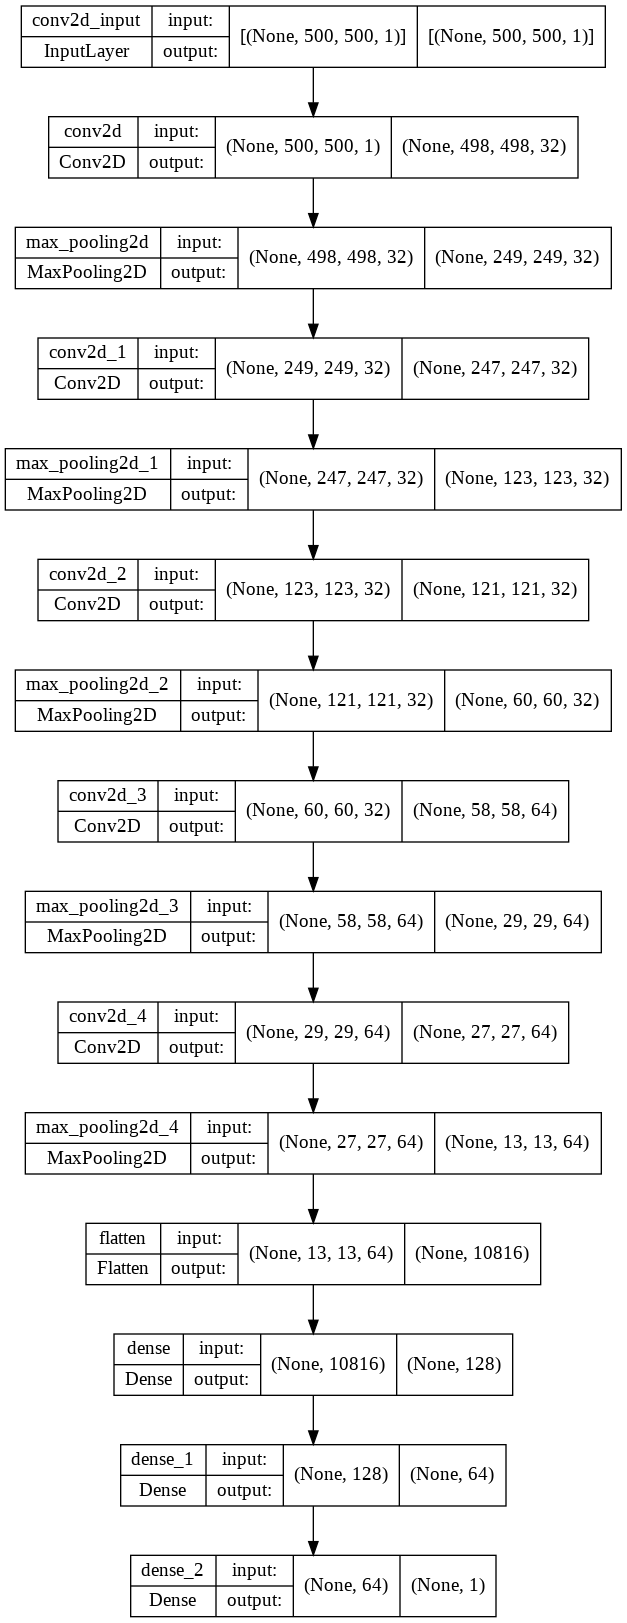

In [ ]:
plot_model(model,
           show_shapes = True, # Whether to display shape information
           show_layer_names = True, # Whether to display layer names
           rankdir = 'TB', # Creates a vertical plot
           expand_nested = True, # Whether to expand nested models into clusters
           to_file = 'model.png')

from IPython.display import Image
Image(retina = True,
      filename = 'model.png')

### Defining Callbacks

Zalan implemented the EarlyStopping function to stop the epochs based on some metric(monitor) and conditions(mode, patience).

In general it helps to reduce overfitting the model, by telling it to stop training based on the validated loss metric, that needs to be minimized.

Patience means that when a minimum "val_loss" is achieved, after that in the next iterations if the "val_loss" increases in any of the 3 iterations, 
then the training should stop at that epoch.

During fitting process, we run the model for 25 epochs with early stopping.

The model stopped after 18 epochs, therefore we changed the code below so it only runs for 18 epochs.

Sandi implemented the ReduceLROnPlateau function to reeduce the learning rate when a metric stopped improving.

Models often benefit from reducing the learning rate by a factor of 2–10 once the learning stagnates.

This callback monitors the quantity and if no improvement is seen for a "patience" number of epochs, the learning rate is reduced.

Damian implemented the ModelCheckpoint function to make sure that our best model gets saved on an ongoing basis during the training.

The "save_best_only = True" argument overwrites the previously saved model, thus ensures that we are left with the absolute best model at the very end.

In [ ]:
early = EarlyStopping(monitor = 'val_loss', # Quantity to be monitored
                      mode = 'min', # Training will stop when the quantity monitored has stopped decreasing
                      patience = 6) # Number of epochs with no improvement after which training will be stopped

learning_rate_reduction = ReduceLROnPlateau(monitor = 'val_loss', # Quantity to be monitored
                                            patience = 2, # Number of epochs with no improvement after which learning rate will be reduced
                                            verbose = 1, # Update messages
                                            factor = 0.2, # Factor by which the learning rate will be reduced: new_lr = lr * factor
                                            min_lr = 0.000001) # Lower bound on the learning rate

checkpoint = ModelCheckpoint(filepath = 'group_11_validated_model.h5',
                             save_best_only = True)

callbacks_list = [early, learning_rate_reduction, checkpoint]
#callbacks_list = [learning_rate_reduction, checkpoint]


### Training the Model

In [ ]:
hist = model.fit(train,
                 epochs = 25,
                 validation_data = valid,
                 callbacks = callbacks_list)

Epoch 1/25
103/103 [==============================] - 316s 3s/step - loss: 0.4341 - accuracy: 0.7718 - val_loss: 0.1821 - val_accuracy: 0.9390 - lr: 0.0010
Epoch 2/25
103/103 [==============================] - 53s 514ms/step - loss: 0.2165 - accuracy: 0.9254 - val_loss: 0.1281 - val_accuracy: 0.9482 - lr: 0.0010
Epoch 3/25
103/103 [==============================] - 54s 524ms/step - loss: 0.1709 - accuracy: 0.9496 - val_loss: 0.1284 - val_accuracy: 0.9482 - lr: 0.0010
Epoch 4/25
103/103 [==============================] - 53s 515ms/step - loss: 0.1483 - accuracy: 0.9466 - val_loss: 0.0968 - val_accuracy: 0.9726 - lr: 0.0010
Epoch 5/25
103/103 [==============================] - 53s 513ms/step - loss: 0.1378 - accuracy: 0.9515 - val_loss: 0.0867 - val_accuracy: 0.9726 - lr: 0.0010
Epoch 6/25
103/103 [==============================] - 54s 525ms/step - loss: 0.1230 - accuracy: 0.9624 - val_loss: 0.0921 - val_accuracy: 0.9634 - lr: 0.0010
Epoch 7/25
103/103 [==============================] - 

### Model Summary

Plotting the model's history allows us to evaluate the performance of the model at each epoch.

It contains the loss function values for train and validation tests, accuracy for train and validation sets and development of the learning rate.

Since the trainig and validation accuracy improved at almost every epoch, we are confident that the model has a potential to give good predictions.

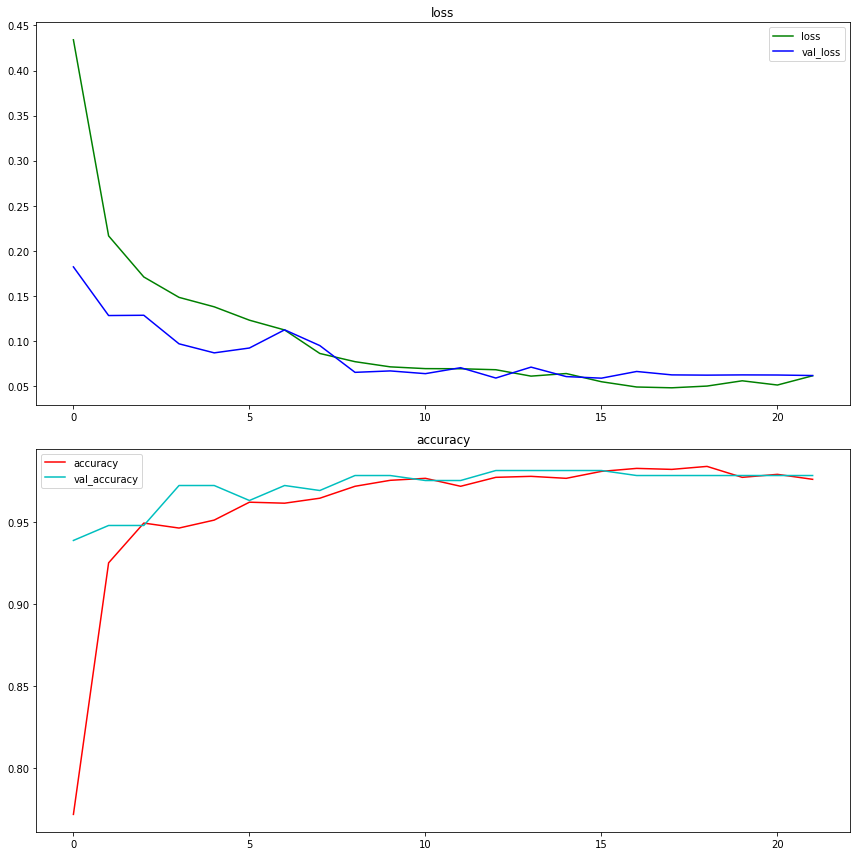

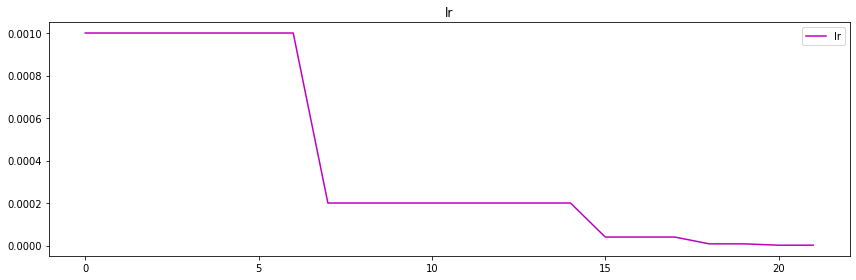

In [ ]:
hist_df = pd.DataFrame(hist.history)
plt.figure(figsize = (12, 12))

for i in [0, 1]:
    colors = ['g', 'r', 'b', 'c', 'm']
    plt.subplot(2, 1, i+1)
    hist_df.iloc[:, i].plot(color = colors[i])
    plt.legend()
    hist_df.iloc[:, i+2].plot(color = colors[i+2])
    plt.title(hist_df.columns[i])
    plt.legend()
plt.tight_layout()
plt.show()

plt.figure(figsize = (12, 4))
hist_df.iloc[:, 4].plot(color = colors[4])
plt.title(hist_df.columns[4])
plt.legend()
plt.tight_layout()
plt.show()

## Evaluation

### Evaluating the Test Accuracy

In [ ]:
evaluation = model.evaluate(test)
accuracy = round(evaluation[1]*100, 3) 
print(f'The testing accuracy is: {accuracy}%')

14/14 [==============================] - 61s 5s/step - loss: 0.0746 - accuracy: 0.9865
The testing accuracy is: 98.649%


Evaluating the model by making prediction on the test dataset gives us an argument, that the model seems to be good at generalizing to unseen data, as the train set accuracy is 95.53%, which is relatively close to the validation accuracy of 98.17%.

### Prediction on the Test dataset

We are making predictions on the test dataset, using another function model.predict().

It returns the probabilities whether an obervation in the test dataset is normal or pneunomia.

If its above thereshold 0.5 defined by us, the model predicts pneumonia, if its below 0.5, the model predicts normal condition.

Especially in the health sector, a thereshold of 0.5 could be way too low, when it comes to handling serious dieseases.

In certain cases one would like to be as certain as possible, that the model clasifies a patient sick or healthy.

In [ ]:
preds = model.predict(test,
                      verbose = 1)

predictions = preds.copy()

predictions[predictions <= 0.5] = 0
predictions[predictions > 0.5] = 1

14/14 [==============================] - 7s 430ms/step


## Visualization

### Confusion Matrix

We have created a Confusion Matrix, which is a contigency table, showing us True Positive, True Negative, False Positive and False Negative predictions.

On the diagonal axis with negative slope we observe the expected values - True Positives and True Negatives.

On the oposite diagonal we observe the misclassifications - False Positives and False Negatives.

The better performing the model, the less misclassifications it will have, based on the threshold defined in the previous step.

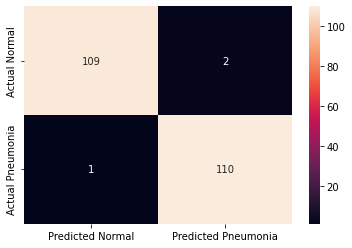

In [ ]:
cm = pd.DataFrame(data = confusion_matrix(test.classes, predictions, labels = [0, 1]),
                  index = ['Actual Normal', 'Actual Pneumonia'],
                  columns = ['Predicted Normal', 'Predicted Pneumonia'])

sns.heatmap(cm,
            annot = True,
            fmt = 'd')

### Plotting Examples of Prediction

Here we created a visualization of 9 predictions of the model and the confidence, expressed in precentage on how confident the model is in predicting the classes of normal or pneumonia.

The example shows that the model gives us a good accuracy preformance on the test data and the misclassified image as normal looks similar 
to the original XRay images from normal condions.

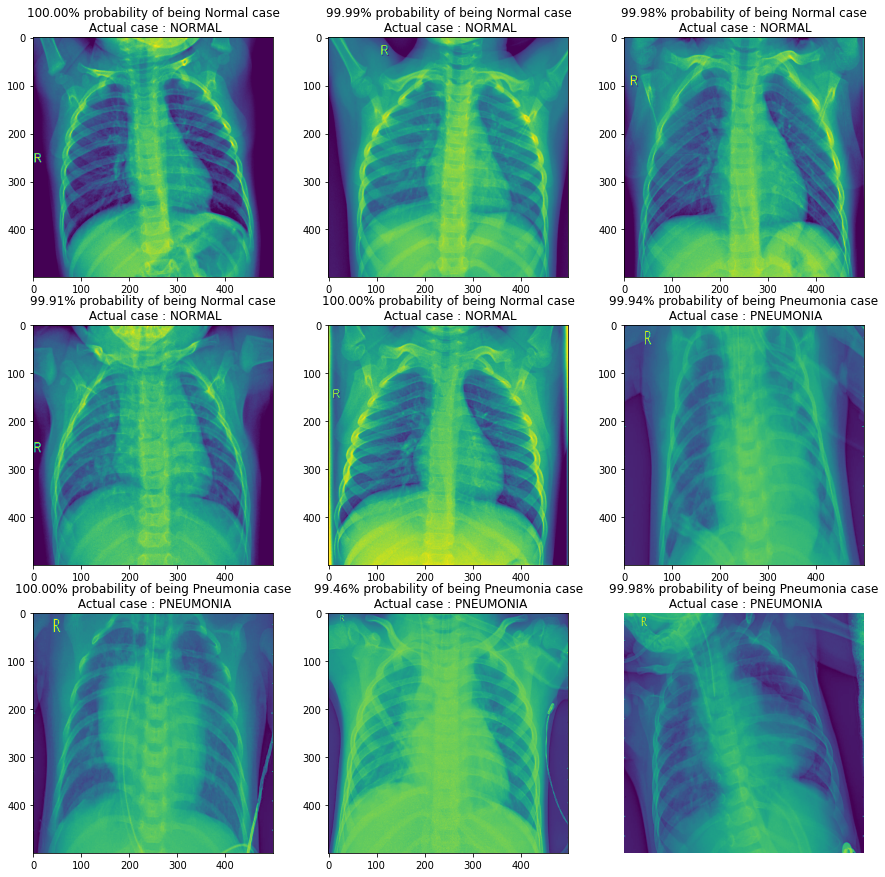

In [ ]:
test.reset()

# Extracting the images from the test data iterator without shuffling the sequence
# x contains the image array
# y contains the labels
x = np.concatenate([test.next()[0] for i in range(test.__len__())])
y = np.concatenate([test.next()[1] for i in range(test.__len__())])

visualize_index = 106
dic = {0:'NORMAL', 1:'PNEUMONIA'}
plt.figure(figsize = (15, 15))

for i in range(0, 9):
  plt.subplot(3, 3, i+1)
  if preds[i+visualize_index, 0] >= 0.5: 
      out = ('{:.2%} probability of being Pneumonia case'.format(preds[i+visualize_index][0]))    
  else: 
      out = ('{:.2%} probability of being Normal case'.format(1-preds[i+visualize_index][0]))
  plt.title(out + "\n Actual case : " + dic.get(y[i+visualize_index]))    
  plt.imshow(np.squeeze(x[i+visualize_index]))

plt.axis('off')
plt.show()

## Testing

### Testing the Model on Completely Unseen data

Purely out of curiosity, we have tested our model on completely unseen images, found online, thus not originating from the given dataset in the assingment, in order to do a final test of the model.

We know the class labels and we run the prediction on the given data, to determine if the model classifies them correctly.

The model correclty assigned the class labels to the new data with high confidence.

The results are visualized below.

In [ ]:
# Testing with a couple of unseen X-Ray images
n_path = '/Users/dtrzc/Library/CloudStorage/OneDrive-Personal/0_MASTERS/3_Deep_Learning/exam/n.png'
p_path = '/Users/dtrzc/Library/CloudStorage/OneDrive-Personal/0_MASTERS/3_Deep_Learning/exam/p.png'

from tensorflow.keras.preprocessing import image
n_img = image.load_img(n_path,
                       target_size = (img_height, img_width),
                       color_mode = 'grayscale')

p_img = image.load_img(p_path,
                       target_size = (img_height, img_width),
                       color_mode = 'grayscale')

# Preprocessing normal image
pp_n_img = image.img_to_array(n_img)
pp_n_img = pp_n_img / 255
pp_n_img = np.expand_dims(pp_n_img,
                          axis = 0)

# Preprocessing pneumonia image
pp_p_img = image.img_to_array(p_img)
pp_p_img = pp_p_img / 255
pp_p_img = np.expand_dims(pp_p_img,
                          axis = 0)

# Predicting
n_preds= model.predict(pp_n_img)
p_preds= model.predict(pp_p_img)

# Plotting prediction on Normal sample
plt.figure(figsize = (6, 6))
plt.axis('off')

if n_preds >= 0.5: 
    out = ('I am {:.2%} percent confident that this is a Pneumonia case'.format(n_preds[0][0]))
else: 
    out = ('I am {:.2%} percent confident that this is a Normal case'.format(1-n_preds[0][0]))

plt.title("NORMAL Chest X-Ray\n" + out)  
plt.imshow(np.squeeze(pp_n_img))

# Plotting prediction on a Pneumonia sample
plt.figure(figsize = (6, 6))
plt.axis('off')

if p_preds >= 0.5: 
    out = ('I am {:.2%} percent confident that this is a Pneumonia case'.format(p_preds[0][0]))
else: 
    out = ('I am {:.2%} percent confident that this is a Normal case'.format(1-p_preds[0][0]))

plt.title("Pneumonia Chest X-Ray\n"+out)
plt.imshow(np.squeeze(pp_p_img))

plt.show()

## Full Training

After testing several models and finding the best performing one using the train, validation and test datasets, we fit the best model to the entire dataset (full training) and save it as full_dataset_model.h5.

### Training Path

In [ ]:
train = image_gen.flow_from_directory(full_folder_path,
                                      target_size = (img_height, img_width),
                                      color_mode = 'grayscale',
                                      class_mode = 'binary',
                                      batch_size = batch_size)

### Getting the Best Model (.h5)

In [ ]:
learning_rate_reduction = ReduceLROnPlateau(monitor = 'loss',
                                            patience = 2,
                                            verbose = 1,
                                            factor = 0.3,
                                            min_lr = 0.000001)

checkpoint = ModelCheckpoint(filepath = 'group_11_full_data_model.h5',
                             save_best_only = True)

callbacks_list = [learning_rate_reduction, checkpoint]

hist = model.fit(train,
                 epochs = 18,
                 callbacks = callbacks_list)

pd.DataFrame(hist.history).plot()